# Analysis Evaluation Result

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from scipy.stats import entropy

##### Global Parameter

In [2]:
MAC = '20:20:00:00:00:06' # Positive
#MAC = '20:20:00:00:01:80' # Unclear
#MAC = '20:20:00:00:00:54'
#MAC = '20:20:00:00:01:50'
#MAC = '20:20:00:00:02:09'

LOSS_DIR = "../log/loss/"
BASE_DIR = "../log/base/"
EVAL_DIR = "../log/eval/"
DATA_DIR = "../dataset/train/"
FLOOR_DIR = "../dataset/floorplan/"

FILENAME = MAC.replace(':','-') + '.csv'
LOSS_FILE = LOSS_DIR + FILENAME
BASE_FILE = BASE_DIR + FILENAME
EVAL_FILE = EVAL_DIR + FILENAME
DATA_FILE = DATA_DIR + FILENAME
FLOOR_FILE = FLOOR_DIR + 'floor2.png'

##### Helper Function

In [3]:
M_IM_UE = np.array([[5.042499029566373,-9.094343319222558,1711.5159967272198],[9.107857664429917,5.048115629191419,-9822.352376387884],[0.0,0.0,1.0]])
M_UE_IM = np.linalg.inv(M_IM_UE)

def ue_to_im(df,xlabel='x', ylabel='y'):
    series = df.apply(lambda x: np.dot(M_UE_IM, np.array([x[xlabel], x[ylabel], 1]))[:2], axis=1)
    df['imx'] = series.map(lambda x: x[0])
    df['imy'] = series.map(lambda x: x[1]) 
    return df

def get_im():
    im =Image.open(FLOOR_FILE)
    return plt.imread(FLOOR_FILE),  im.height * 1.0 / im.width

## Load Data

In [4]:
loss_df = pd.read_csv(LOSS_FILE)
loss_df = ue_to_im(loss_df)
loss_df.x *= 0.01
loss_df.y *= 0.01
display(loss_df[:1])

base_df = pd.read_csv(BASE_FILE)
base_df = ue_to_im(base_df)
base_df.x *= 0.01
base_df.y *= 0.01
display(base_df[:1])

eval_df = pd.read_csv(EVAL_FILE)
eval_df = ue_to_im(eval_df)
eval_df.x *= 0.01
eval_df.y *= 0.01
display(eval_df[:1])

data_df = pd.read_csv(DATA_FILE)
data_df = ue_to_im(data_df, xlabel='UE_X', ylabel='UE_Y')
data_df['x'] = data_df.UE_X * 0.01
data_df['y'] = data_df.UE_Y * 0.01
display(data_df[:1])

,iteration,x,y,power,loss,imx,imy
0,1,30.193901,5.52409,43.668397,6.866817e-08,932.297605,373.11497


,x,y,rss prediction,rss label,imx,imy
0,34.50042,13.327971,-79,-54,1017.915085,373.233084


,x,y,rss prediction,rss label,imx,imy
0,11.384005,-4.428207,-80,-84,761.023685,484.980225


,Timestamp,X,Y,Floor ID,SSID,MAC,Frequency,RSS,Trajectory,Floor Confident,UE_X,UE_Y,imx,imy,x,y
0,62.467,878.539073,294.925607,2,SSID_0001,20:20:00:00:00:06,2437,-70,T02_01,1.0,3459.393699,-331.924982,878.539073,294.925607,34.593937,-3.31925


## Signal Distribution

C:\Users\zhong\AppData\Local\Temp\ipykernel_15812\3154656465.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, pad=0.01,aspect=50)


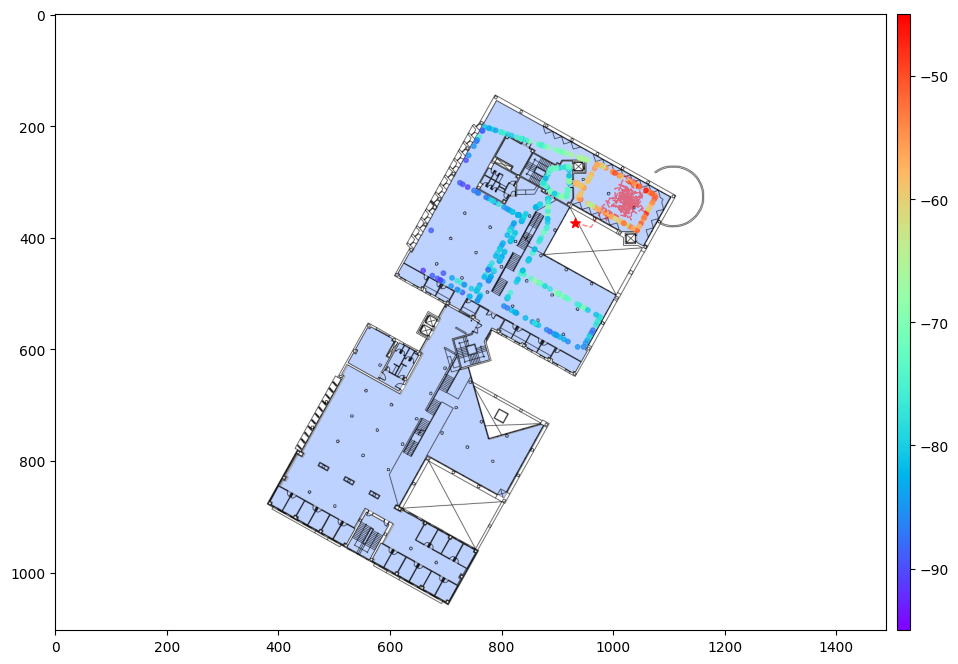

In [5]:
im, ratio = get_im()
fig, ax = plt.subplots(figsize=(15,8))
im = ax.imshow(im)

rss_max, rss_min = -45, -95
colors = plt.cm.rainbow(np.linspace(0, 1, rss_max-rss_min+1))
data_df['Color'] = data_df.apply(lambda row : colors[int(row['RSS']) - rss_min], axis = 1)

plt.scatter(loss_df.imx[:1], loss_df.imy[:1], marker='*',s=50, color='red', alpha=1, label='trace start')
plt.plot(loss_df.imx, loss_df.imy, color='red', linestyle='--', linewidth=1, label='fitting trace', alpha=0.5)

plt.scatter(data_df.imx, data_df.imy, marker='o',s=10, color=data_df['Color'], alpha=0.75)

cmap = cm.get_cmap('rainbow')       
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(rss_min, rss_max))
cbar = fig.colorbar(sm, pad=0.01,aspect=50)
plt.show()

### RSS Distribution

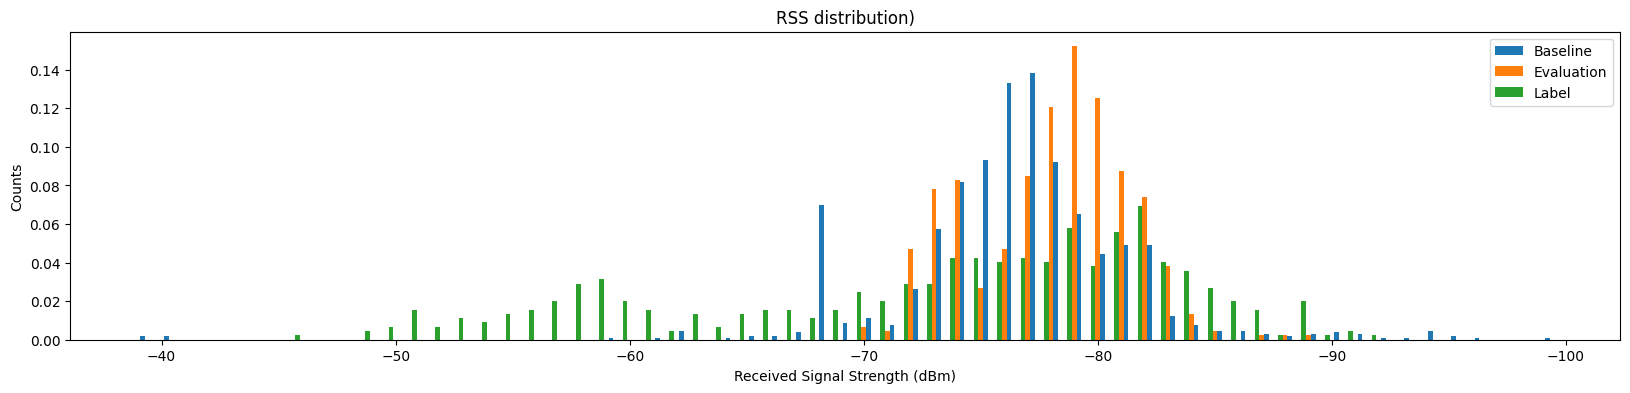

KL Divergence(real||base): 12.180403994265289
KL Divergence(real||eval): 1.005521865538346


In [6]:
def plot_rss_distribution(base_df, eval_df, rss_lowerbound = -100):
    
    base_fdf = base_df[base_df['rss prediction'] > rss_lowerbound]
    eval_fdf = eval_df[eval_df['rss prediction'] > rss_lowerbound]
    
    base_valuecounts  = base_fdf['rss prediction'].value_counts() / len(base_fdf)
    eval_valuecounts  = eval_fdf['rss prediction'].value_counts() / len(eval_fdf)
    label_valuecounts = eval_fdf['rss label'].value_counts() / len(eval_fdf)

    plt.figure(figsize=(20,4))
    
    base_valuecounts = base_valuecounts.sort_index()
    eval_valuecounts = eval_valuecounts.sort_index()
    label_valuecounts = label_valuecounts.sort_index()

    
    plt.bar(base_valuecounts.index - 0.2,  base_valuecounts.values,  width=0.2, label='Baseline')
    plt.bar(eval_valuecounts.index,        eval_valuecounts.values,  width=0.2, label='Evaluation')
    plt.bar(label_valuecounts.index + 0.2, label_valuecounts.values, width=0.2, label='Label')
    
    plt.title(f"RSS distribution)")
    plt.xlabel("Received Signal Strength (dBm)")
    plt.ylabel("Counts")
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()
    
    rss_min = np.min([np.min(base_valuecounts.index), np.min(eval_valuecounts.index), np.min(label_valuecounts.index)])
    rss_max = np.max([np.max(base_valuecounts.index), np.max(eval_valuecounts.index), np.max(label_valuecounts.index)])
    
    base_prob = []
    eval_prob = []
    label_prob = []
    
    eps = 1e10-10
    
    for rss in list(np.arange(rss_min,rss_max,1)):
        if rss in base_valuecounts.index:
            base_prob.append(base_valuecounts[rss])
        else:
            base_prob.append(eps)
            
        if rss in eval_valuecounts.index:
            eval_prob.append(eval_valuecounts[rss])
        else:
            eval_prob.append(eps)
        
        if rss in label_valuecounts.index:
            label_prob.append(label_valuecounts[rss])
        else:
            label_prob.append(eps)
    
    
    print("KL Divergence(real||base):", entropy(label_prob, base_prob))
    print("KL Divergence(real||eval):", entropy(label_prob, eval_prob))

plot_rss_distribution(base_df, eval_df)

## Visualize Difference

In [7]:
RSS_DIFF_LB = -155

eval_df['rss diff'] = eval_df['rss prediction'] - eval_df['rss label']
base_df['rss diff'] = base_df['rss prediction'] - base_df['rss label']
base_data =base_df[base_df['rss diff'] > RSS_DIFF_LB]
eval_data =eval_df[eval_df['rss diff'] > RSS_DIFF_LB]

### Difference

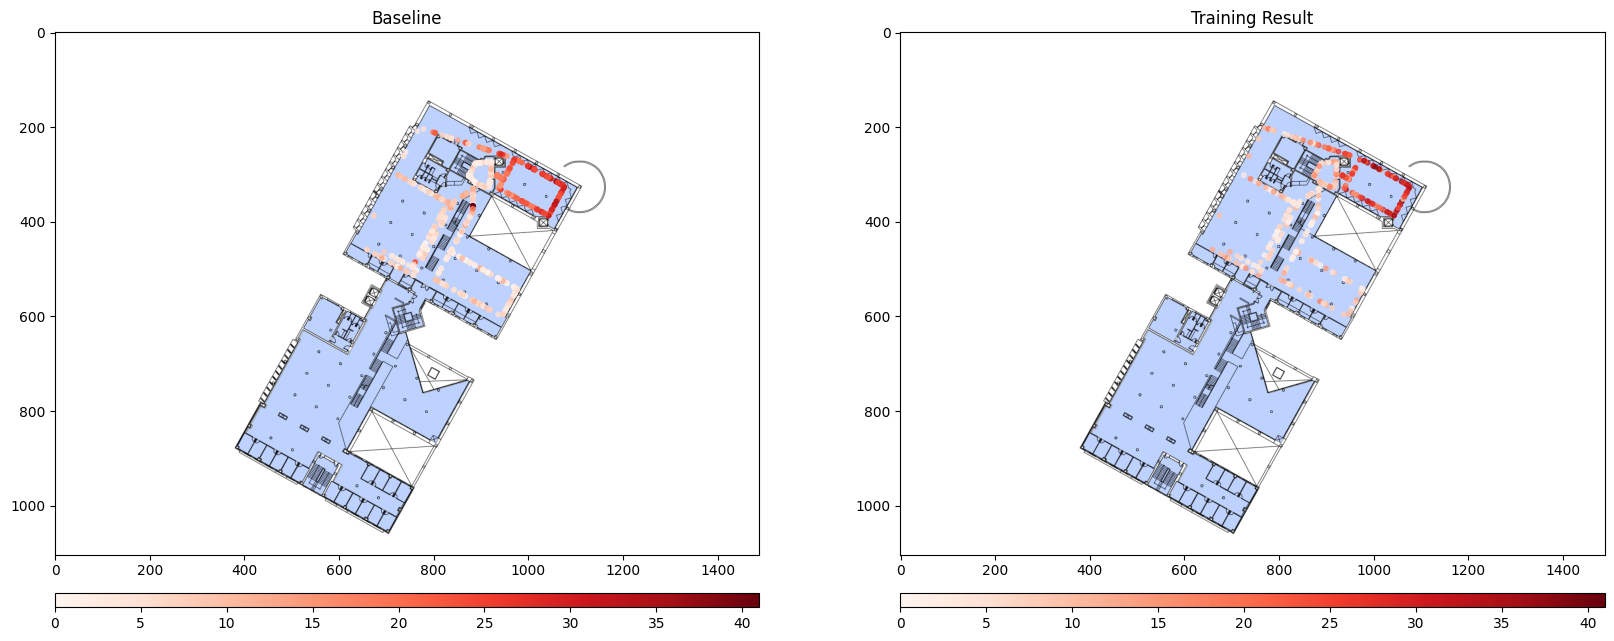

In [12]:
import signals

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
im, ratio = get_im()
axs[0].imshow(im)
axs[1].imshow(im)

# Choose colormap
cmap = cm.get_cmap('Reds')

base_diff =  np.abs(base_data['rss diff'])
base_weights = (base_diff - np.min(base_diff))/ (np.max(base_diff) - np.min(base_diff))
axs[0].scatter(base_data.imx, base_data.imy, c=cmap(base_weights), marker='o',s=10, alpha=0.75)
axs[0].set_title("Baseline")

eval_diff =  np.abs(eval_data['rss diff'])
eval_weights = (eval_diff - np.min(eval_diff))/ (np.max(eval_diff) - np.min(eval_diff))
axs[1].scatter(eval_data.imx, eval_data.imy, c=cmap(eval_weights), marker='o',s=10, alpha=0.75)
axs[1].set_title("Training Result")

min_b = min(min(base_diff), min(eval_diff))
max_b = max(max(base_diff), max(eval_diff))

sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_b, max_b))
cbar = fig.colorbar(sm, ax=axs[0], pad=0.05, orientation='horizontal',aspect=50)
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_b, max_b))
cbar = fig.colorbar(sm, ax=axs[1], pad=0.05, orientation='horizontal',aspect=50)
plt.show()

### Difference

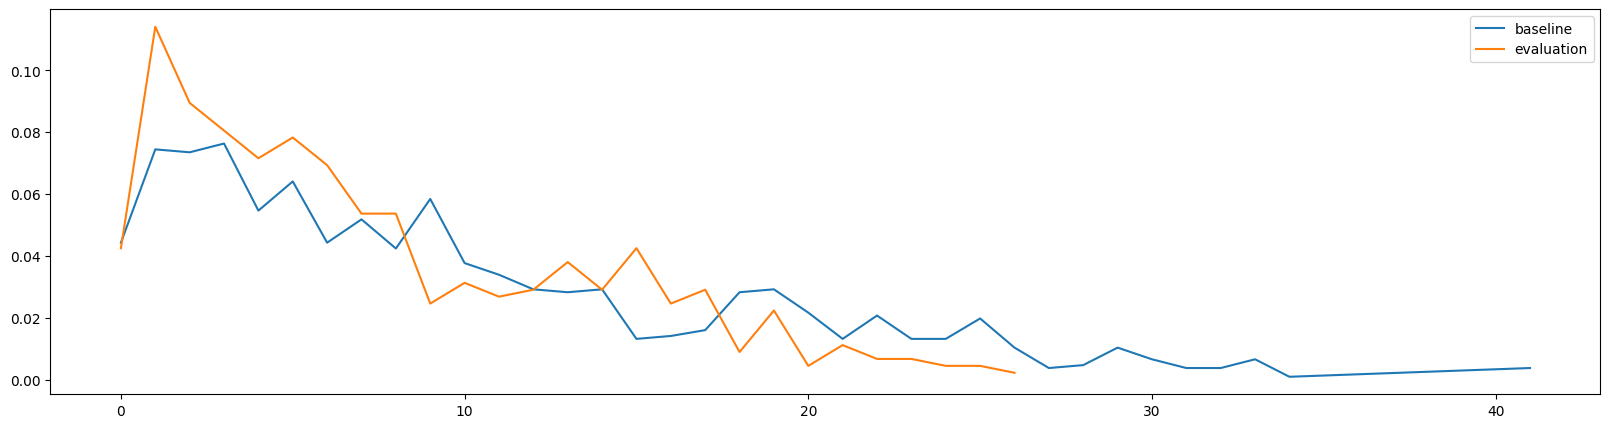

In [9]:
base_diff =  np.abs(base_data['rss diff'])
base_diff_pct = (base_diff.value_counts() / len(base_diff)).sort_index()
eval_diff =  np.abs(eval_data['rss diff'])
eval_diff_pct = (eval_diff.value_counts() / len(eval_diff)).sort_index()

plt.figure(figsize=(20,5))
plt.plot(base_diff_pct.index, base_diff_pct.values, label='baseline')
plt.plot(eval_diff_pct.index, eval_diff_pct.values, label='evaluation')
plt.legend()
plt.show()

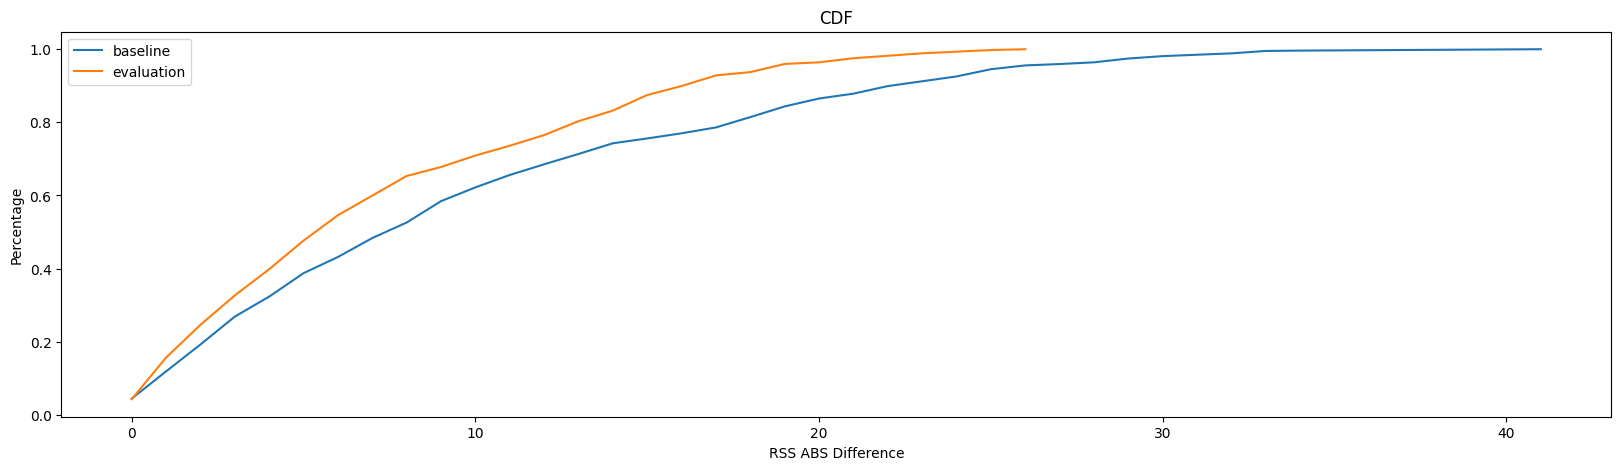

In [10]:
base_diff_pct_cdf = []
eval_diff_pct_cdf = []

total = 0
for i in base_diff_pct.index:
    total += base_diff_pct[i]
    base_diff_pct_cdf.append([i, total])
base_diff_pct_cdf = np.array(base_diff_pct_cdf)

total = 0
for i in eval_diff_pct.index:
    total += eval_diff_pct[i]
    eval_diff_pct_cdf.append([i, total])
eval_diff_pct_cdf = np.array(eval_diff_pct_cdf)

plt.figure(figsize=(20,5))
plt.plot(base_diff_pct_cdf[:,0],base_diff_pct_cdf[:,1], label="baseline")
plt.plot(eval_diff_pct_cdf[:,0],eval_diff_pct_cdf[:,1], label="evaluation")
plt.title('CDF')
plt.xlabel('RSS ABS Difference')
plt.ylabel('Percentage')
plt.legend()
plt.show()    